# Input Data Preprocessing
This Jupyter notebook contains code to process weather station data into a single .csv from multiple messy files. Once you complete this script, move to process_AWS to complete the data cleaning process.

In [1]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths. "folder" should be a folder containing only the files you wish to concatenate.

In [ ]:
# FILEPATHS
data_fp = '../../../climate_data/AWS/Raw/'          # Filepath to the folder of input data
folder = data_fp + 'naluday/'                       # Filepath of the folder containing the messy files
file_type = 'txt'                                   # Choose the file type (csv, txt or xlsx)

The following block produces a dataframe from all concatenated files and renames the columns. In the example, the data had unnamed columns, so the variables were manually named in col_names. You will need to edit this code to get the right column names and the right time format. You should end up with one dataframe with human-readable column names for each variable.

In [ ]:
# Concatenate files in folder
fn_list = os.listdir(folder)
fn_list = [f for f in fn_list if file_type in f]

col_names = ['DateTime','Pressure','Temperature','RH','Wind','Gust','Winddir','SWin','SWout','LWin','LWout']
for fn in fn_list:
    # Open the file
    df = pd.read_csv(folder + fn, index_col=0,          # Base arguments, assumes column 0 is the datetime
                            sep='\t',                   # Delimiter/separater
                            skiprows=3,                 # How many rows of metadata
                            encoding='ISO-8859-1',      # Encoding
                            engine='python',            # Engine to open the file
                            names = col_names)          # Specify the names of the columns
    
    # Get timezone
    with open(folder + fn, 'r') as f:
        lines = f.readlines()
    second_line = lines[1]
    zone_minutes = int(second_line.split('UTC')[-1].split(' ')[1])
    timezone = pd.Timedelta(minutes=zone_minutes)

    # Skip empty files
    if len(df.index) == 0:
        continue
    
    # Process the datetime column to be in the right format
    if len(str(df.index[0])) > 8:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y %H:%M:%S') - timezone
    else:
        df.index = pd.to_datetime(df.index, format='%m/%d/%y') - timezone

    # Concatenate files
    if fn == fn_list[0]:
        df_all = df.copy(deep=True)
    else:
        df_all = pd.concat([df_all, df],axis=0)
df_all = df_all.sort_index()
df_all = df_all[pd.to_datetime(df_all.index).second == 0]
df_all

,Pressure,Temperature,RH,Wind,Gust,Winddir,SWin,SWout,LWin,LWout
DateTime,,,,,,,,,,
2019-08-28 18:00:00,15.796,-0.000,-0.000,-2.000,-2.000,NaN,NaN,NaN,NaN,NaN
2019-08-28 19:00:00,16.463,-0.000,-0.000,-2.000,-2.000,NaN,NaN,NaN,NaN,NaN
2019-08-29 20:00:00,20.984,0.016,20.562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-31 00:00:00,19.603,49.200,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-31 01:00:00,19.484,49.400,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-07-16 07:00:00,863.450,8.045,69.500,3.508,7.016,131.969,-1.56,0.01,329.74,353.92
2025-07-16 08:00:00,863.150,8.145,69.200,4.210,7.016,131.969,-2.05,0.00,324.64,351.10
2025-07-16 09:00:00,863.550,8.568,66.300,1.403,5.613,134.776,-1.82,0.04,331.53,351.61


## Inspect data fullness

This plot can help you decide whether to process the data all together or split it into separate files (e.g., if there is a large data gap)

In [7]:
# Print data counts
df_all.count()

Pressure       50164
Temperature    50164
RH             50164
Wind           50163
Gust           50125
Winddir        50123
SWin           32974
SWout          36289
LWin           37272
LWout          37272
dtype: int64

In [ ]:
# optionally drop outgoing fluxes if you want to calculate albedo/surface temperature 
# (comment this block if you want to keep that data or don't have those variables)
df_all = df_all.drop(columns=['SWout','LWout'])

Create a plot that shows over the entire time period where all variables were measured

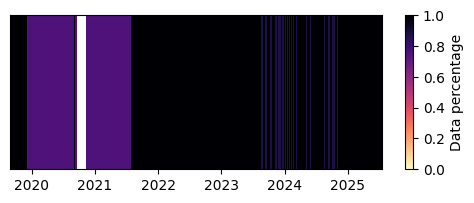

In [ ]:
# this block takes a minute to run so you may want to set plot=False if rerunning the notebook multiple times
plot = True
if plot:
    fig, ax = plt.subplots(figsize=(6,2))
    all_percentage = []
    
    # check how many variables are full in each timestep
    for row in df_all.index:
        percent = df_all.loc[row].count() / len(df_all.columns)
        all_percentage.append(percent)
    
    # define colormap
    cmap = plt.get_cmap('magma_r')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # plot bars for each timestep
    ax.bar(df_all.index, 1, pd.Timedelta(hours=1), color=cmap(norm(all_percentage)))

    # beautify plot
    ax.set_xlim(df_all.index[0], df_all.index[-1])
    ax.set_ylim(0,1)
    ax.set_yticks([])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Data percentage',orientation='vertical')
    plt.show()

The function find_data_periods will find periods of a certain length (min_months) that contain a certain percentage of data (coverage_threshold). It also checks that the period doesn't start or end with any NaNs, as endmembers cannot be interpolated out. The function returns the periods that can be used as inputs to run PEBSI.

In [11]:
def find_data_periods(df, min_months=4, coverage_threshold=0.9):
    df = df.sort_index()
    min_hours = int(min_months * 30 * 24)  # ~4 months in hours

    # mask: only rows where all variables are present
    is_complete = df.notna().all(axis=1)

    # group by breaks in continuity
    block_ids = (~is_complete).cumsum()
    blocks = df[is_complete].groupby(block_ids)

    results = []
    for _, block in blocks:
        # block must be at least min_hours long
        if len(block) < min_hours:
            continue

        # can't have NaNs at the beginning or end of the record
        start_ok = block.iloc[0].notna().all()
        end_ok = block.iloc[-1].notna().all()

        # determine percentage of data that is there
        coverage = block.notna().sum().sum() / block.size

        # don't include blocks that start at a weird time interval; only top or bottom of the minute
        if block.index[0].second != 0:
            block = block.iloc[1:]
        if block.index[-1].second != 0:
            block = block.iloc[:-1]

        # check if this is a valid block
        if start_ok and end_ok and coverage >= coverage_threshold:
            results.append((block.index[0], block.index[-1]))

    print(f'Found {len(results)} continuous periods')
    return results

blocks = find_data_periods(df_all)
print(blocks)

Found 2 continuous periods
[(Timestamp('2021-07-25 08:00:00'), Timestamp('2023-08-08 05:00:00')), (Timestamp('2024-11-01 15:00:00'), Timestamp('2025-07-16 11:00:00'))]


If any timestamps are missing, they should be filled with NaNs which will then be interpolated out in processing.ipynb.

In [ ]:
# fill missing timestamps with NaNs
dfs = []
for b,block in enumerate(blocks):
    time = pd.date_range(block[0], block[1], freq='h')
    block_df = df_all.reindex(time)
    dfs.append(block_df.loc[time])
    print(f'Total number of timesteps in block {b}: ',len(block_df.index))

Total n points in block 0:  17854
Total n points in block 1:  6165


In [81]:
for d,df in enumerate(dfs):
    start_year = df.index[0].year
    fn = folder + f'preprocessed_{start_year}.csv'
    df.to_csv(fn)
    print(f'Saved dataframe {d} to {fn}: {df.index[0].date()} to {df.index[-2].date()}')

Saved dataframe 0 to ../climate_data/AWS/Raw/naluday/preprocessed_2021.csv: 2021-07-25 to 2023-08-08
Saved dataframe 1 to ../climate_data/AWS/Raw/naluday/preprocessed_2024.csv: 2024-11-01 to 2025-07-16
